# <span style="color:#6495ED">**Abnormal behavior in cellular networks predictor**</span>

Gil Jiménez Canellas, Machine Learning Seminar, ETSETB, UPC. 2024

> Competition Link: https://www.kaggle.com/competitions/abnomal-behavior-in-cellular-networks

> Report Link:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPRegressor

### <span style="color:#6495ED">**1. Division between train and test data**</span>

First we are going to make the division between train and test data using `train_test_split`.

In [4]:
# path = '/home/gil/Telecos/3B/APA/LAB/Competition/data/'
# train = pd.read_csv(path + 'ML-MATT-CompetitionQT2021_train.csv', delimiter=';')
# test = pd.read_csv(path + 'ML-MATT-CompetitionQT2021_test.csv', delimiter=';')

from google.colab import drive
drive.mount('/content/drive')
file_path_train = '/content/drive/My Drive/APA/Competition/data/ML-MATT-CompetitionQT2021_train.csv'
file_path_test = '/content/drive/My Drive/APA/Competition/data/ML-MATT-CompetitionQT2021_test.csv'
train = pd.read_csv(file_path_train, delimiter=';')
test = pd.read_csv(file_path_test, delimiter=';')

# Drop CellName and prepare Time
train = train.drop(columns=['CellName'])
time_parts = train['Time'].str.split(':', expand=True).astype(int)
seconds_since_midnight = (time_parts[0] * 60) + time_parts[1]
train['Time'] = seconds_since_midnight

# Drop CellName and prepare Time
test = test.drop(columns=['CellName'])
time_parts = test['Time'].str.split(':', expand=True).astype(int)
seconds_since_midnight = (time_parts[0] * 60) + time_parts[1]
test['Time'] = seconds_since_midnight
test = test.drop(columns=['ID'])

  # Remove all non-numeric characters
test['maxThr_DL'] = test['maxThr_DL'].replace('[^\d]', '', regex=True)
test['maxThr_DL'] = test['maxThr_DL'].str.replace(r'(\d+\.\d+)(.*)', r'\1', regex=True).astype(float)

# Separate majority and minority classes
normal = train[train['Unusual'] == 0]
abnormal = train[train['Unusual'] == 1]

# Undersample majority class to match the desired ratio
from sklearn.utils import resample
desired_normal_count = int(len(abnormal) / 0.5 * 0.5)  # Calculate the desired number of samples for the majority class
undersampled_normal = resample(normal, replace=False, n_samples=desired_normal_count, random_state=42)

# Combine minority class with undersampled majority class
train = pd.concat([undersampled_normal, abnormal])

# Shuffle the dataframe
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

print("Percentage of 1s in balanced data:", (train['Unusual'] == 1).mean() * 100)
print("Percentage of 0s in balanced data:", (train['Unusual'] == 0).mean() * 100)

X = train.drop('Unusual', axis=1)
y = train['Unusual']

print(X.head())
print(y.head())
print(test.head())

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mounted at /content/drive
Percentage of 1s in balanced data: 50.0
Percentage of 0s in balanced data: 50.0
   Time  PRBUsageUL  PRBUsageDL  meanThr_DL  meanThr_UL  maxThr_DL  maxThr_UL  \
0  1305     20.3531      6.2096      1.0809      0.9075    20.5033     1.7199   
1   405      1.0110      0.5050      0.3180      0.0350     8.4680     0.5380   
2   645      6.8391      1.0124      0.2372      0.0293     7.9899     0.6414   
3  1065      1.0065      2.1870      0.1972      0.0266    11.8405     0.4458   
4    90      0.1030      0.3975      0.0330      0.0120     0.1442     0.0359   

   meanUE_DL  meanUE_UL  maxUE_DL  maxUE_UL  maxUE_UL+DL  
0     1.3668     1.2330         6         4           10  
1     1.0210     1.0110         2         2            4  
2     1.1624     1.1281         5         4            9  
3     1.1357     0.0100         4         4            8  
4     1.0337     0.0101         2         1            3  
0    1
1    0
2    1
3    1
4    1
Name: Unusual, dty

### <span style="color:#6495ED">**2. Evaluation of several supervised learning models**</span>

In this second bloc, we are going to evaluate several supervised learning models, to find which models have the best `F1-score`. The models that we are going to try are the following ones:

* RandomForestClassifier
* LogisticRegression
* SVC
* DecisionTreeClassifier
* GaussianNB
* KNeighborsClassifier
* AdaBoostClassifier


  
---
---

Each estimator is associated with a tuple consisting of the classification model and a dictionary of hyperparameters with their possible values. This will allow exploring different combinations of estimators and hyperparameters to find the best configuration for our specific classification problem.

In [ ]:
estimators = [
    (RandomForestClassifier(), {'n_estimators': [10, 50, 10], 'max_depth': [None, 5, 10]}),
    (DecisionTreeClassifier(), {'max_depth': [None, 5, 10]}),
    (GaussianNB(), {}),
    (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    (AdaBoostClassifier(), {'n_estimators': [50, 100, 200]}),
]

In [ ]:
estimator_names = []
accuracy_scores = []
recall_scores = []
f1_scores = []

for estimator, param_grid in estimators:
    grid_search = GridSearchCV(estimator, param_grid)
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_

    best_estimator.fit(X_train, y_train)
    y_pred = best_estimator.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    estimator_names.append(best_estimator.__class__.__name__)
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    f1_scores.append(f1)
    print(grid_search.best_params_ )

{'max_depth': None, 'n_estimators': 50}
{'max_depth': None}
{}
{'n_neighbors': 5}
{'n_estimators': 200}


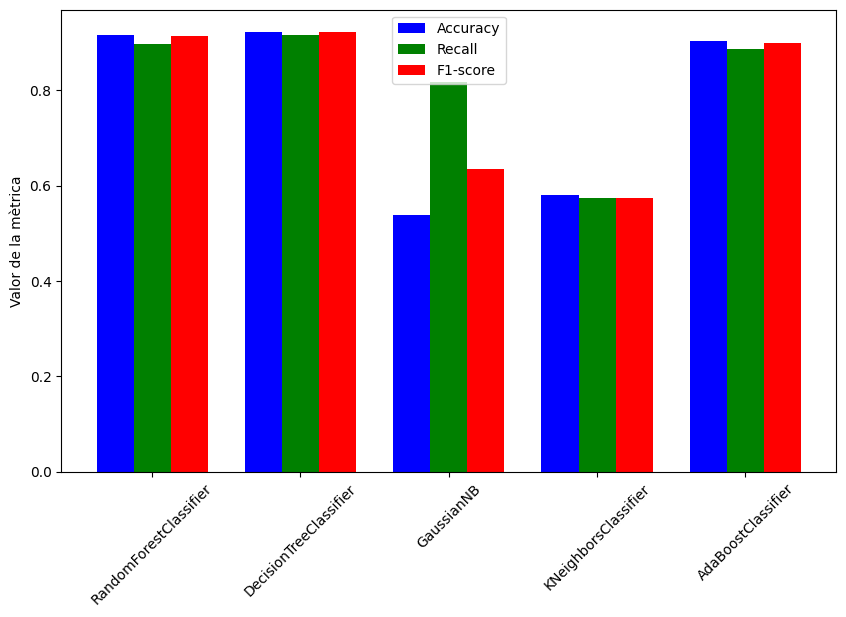

In [ ]:
plt.figure(figsize=(10, 6))
x = range(len(estimator_names))
bar_width = 0.25

plt.bar(x, accuracy_scores, width=bar_width, label='Accuracy', color='b')
plt.bar([i + bar_width for i in x], recall_scores, width=bar_width, label='Recall', color='g')
plt.bar([i + 2 * bar_width for i in x], f1_scores, width=bar_width, label='F1-score', color='r')

plt.ylabel('Valor de la mètrica')
plt.xticks([i + bar_width for i in x], estimator_names, rotation=45)
plt.legend()

plt.show()

We are going to choose the three best models, based on the performance.

In [ ]:
f1 = np.array(f1_scores)
estimator_name = np.array(estimator_names)
indices_top3 = np.argsort(f1)[-3:]

for indice in indices_top3:
    print("Estimador:", estimator_name[indice])
    print("F1-score:", f1[indice])
    print("-----------------------")

Estimador: AdaBoostClassifier
F1-score: 0.8991105463786531
-----------------------
Estimador: RandomForestClassifier
F1-score: 0.9135865409125669
-----------------------
Estimador: DecisionTreeClassifier
F1-score: 0.9210261569416499
-----------------------


#3. Decision Tree

In [12]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
decision_tree = DecisionTreeClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(decision_tree, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_decision_tree = grid_search.best_estimator_

print(best_decision_tree)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10)


In [13]:
dt = best_decision_tree

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.9204066451772873


# 4.Random Forest

In [14]:
from google.colab import drive
drive.mount('/content/drive')
file_path_train = '/content/drive/My Drive/APA/Competition/data/ML-MATT-CompetitionQT2021_train.csv'
file_path_test = '/content/drive/My Drive/APA/Competition/data/ML-MATT-CompetitionQT2021_test.csv'
train = pd.read_csv(file_path_train, delimiter=';')
test = pd.read_csv(file_path_test, delimiter=';')

# Drop CellName and prepare Time
train = train.drop(columns=['CellName'])
time_parts = train['Time'].str.split(':', expand=True).astype(int)
seconds_since_midnight = (time_parts[0] * 60) + time_parts[1]
train['Time'] = seconds_since_midnight

# Drop CellName and prepare Time
test = test.drop(columns=['CellName'])
time_parts = test['Time'].str.split(':', expand=True).astype(int)
seconds_since_midnight = (time_parts[0] * 60) + time_parts[1]
test['Time'] = seconds_since_midnight
test = test.drop(columns=['ID'])

  # Remove all non-numeric characters
test['maxThr_DL'] = test['maxThr_DL'].replace('[^\d]', '', regex=True)
test['maxThr_DL'] = test['maxThr_DL'].str.replace(r'(\d+\.\d+)(.*)', r'\1', regex=True).astype(float)

# Separate majority and minority classes
normal = train[train['Unusual'] == 0]
abnormal = train[train['Unusual'] == 1]

# Undersample majority class to match the desired ratio
from sklearn.utils import resample
desired_normal_count = int(len(abnormal) / 0.5 * 0.5)  # Calculate the desired number of samples for the majority class
undersampled_normal = resample(normal, replace=False, n_samples=desired_normal_count, random_state=42)

# Combine minority class with undersampled majority class
train = pd.concat([undersampled_normal, abnormal])

# Shuffle the dataframe
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

print("Percentage of 1s in balanced data:", (train['Unusual'] == 1).mean() * 100)
print("Percentage of 0s in balanced data:", (train['Unusual'] == 0).mean() * 100)

X = train.drop('Unusual', axis=1)
y = train['Unusual']

print(X.head())
print(y.head())
print(test.head())

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Percentage of 1s in balanced data: 50.0
Percentage of 0s in balanced data: 50.0
   Time  PRBUsageUL  PRBUsageDL  meanThr_DL  meanThr_UL  maxThr_DL  maxThr_UL  \
0  1305     20.3531      6.2096      1.0809      0.9075    20.5033     1.7199   
1   405      1.0110      0.5050      0.3180      0.0350     8.4680     0.5380   
2   645      6.8391      1.0124      0.2372      0.0293     7.9899     0.6414   
3  1065      1.0065      2.1870      0.1972      0.0266    11.8405     0.4458   
4    90      0.1030      0.3975      0.0330      0.0120     0.1442     0.0359   

   meanUE_DL  meanUE_UL  maxUE_DL  maxUE_UL  maxUE_UL+DL  
0     1.3668     1.2330         6         4           10  
1     1.0210     1.0110         2         2            4  
2     1.1624     1.1281         5         4            9  
3     1.1357     0.0100         4         4            8  
4     1.0

In [ ]:
# Define parameter grid for Random Forest
param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}

# Initialize Random Forest Classifier
random_forest = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(random_forest, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# Get the best estimator from the grid search
best_random_forest = grid_search.best_estimator_

In [ ]:
rf = best_random_forest

rf.fit(X_train, y_train.values.ravel())

y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.9184505606523956


# 5.Ada Boost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path_train = '/content/drive/My Drive/APA/Competition/data/ML-MATT-CompetitionQT2021_train.csv'
file_path_test = '/content/drive/My Drive/APA/Competition/data/ML-MATT-CompetitionQT2021_test.csv'
train = pd.read_csv(file_path_train, delimiter=';')
test = pd.read_csv(file_path_test, delimiter=';')

# Drop CellName and prepare Time
train = train.drop(columns=['CellName'])
time_parts = train['Time'].str.split(':', expand=True).astype(int)
seconds_since_midnight = (time_parts[0] * 60) + time_parts[1]
train['Time'] = seconds_since_midnight

# Drop CellName and prepare Time
test = test.drop(columns=['CellName'])
time_parts = test['Time'].str.split(':', expand=True).astype(int)
seconds_since_midnight = (time_parts[0] * 60) + time_parts[1]
test['Time'] = seconds_since_midnight
test = test.drop(columns=['ID'])

  # Remove all non-numeric characters
test['maxThr_DL'] = test['maxThr_DL'].replace('[^\d]', '', regex=True)
test['maxThr_DL'] = test['maxThr_DL'].str.replace(r'(\d+\.\d+)(.*)', r'\1', regex=True).astype(float)

# Separate majority and minority classes
normal = train[train['Unusual'] == 0]
abnormal = train[train['Unusual'] == 1]

# Undersample majority class to match the desired ratio
from sklearn.utils import resample
desired_normal_count = int(len(abnormal) / 0.5 * 0.5)  # Calculate the desired number of samples for the majority class
undersampled_normal = resample(normal, replace=False, n_samples=desired_normal_count, random_state=42)

# Combine minority class with undersampled majority class
train = pd.concat([undersampled_normal, abnormal])

# Shuffle the dataframe
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

print("Percentage of 1s in balanced data:", (train['Unusual'] == 1).mean() * 100)
print("Percentage of 0s in balanced data:", (train['Unusual'] == 0).mean() * 100)

X = train.drop('Unusual', axis=1)
y = train['Unusual']

print(X.head())
print(y.head())
print(test.head())

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Percentage of 1s in balanced data: 50.0
Percentage of 0s in balanced data: 50.0
   Time  PRBUsageUL  PRBUsageDL  meanThr_DL  meanThr_UL  maxThr_DL  maxThr_UL  \
0  1305     20.3531      6.2096      1.0809      0.9075    20.5033     1.7199   
1   405      1.0110      0.5050      0.3180      0.0350     8.4680     0.5380   
2   645      6.8391      1.0124      0.2372      0.0293     7.9899     0.6414   
3  1065      1.0065      2.1870      0.1972      0.0266    11.8405     0.4458   
4    90      0.1030      0.3975      0.0330      0.0120     0.1442     0.0359   

   meanUE_DL  meanUE_UL  maxUE_DL  maxUE_UL  maxUE_UL+DL  
0     1.3668     1.2330         6         4           10  
1     1.0210     1.0110         2         2            4  
2     1.1624     1.1281         5         4            9  
3     1.1357     0.0100         4         4            8  
4     1.0

In [ ]:
# Define parameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.1, 1.0],  # Weight of each weak learner
}

# Initialize AdaBoost Classifier
adaboost = AdaBoostClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(adaboost, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# Get the best estimator from the grid search
best_adaboost = grid_search.best_estimator_

In [ ]:
ab = best_adaboost

# Train the best estimator on the entire training data
ab.fit(X_train, y_train.values.ravel())

y_pred = ab.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.8991105463786531


# 6. Voting

In [ ]:
from sklearn.ensemble import VotingClassifier
voting_hard = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('ab', ab)],
    voting='hard'
)
voting_hard.fit(X_train, y_train)

voting_soft = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('ab', ab)],
    voting='soft'
)
voting_soft.fit(X_train, y_train)

models = [('dt', dt), ('rf', rf), ('ab', ab), ('hard voting', voting_hard), ('soft voting', voting_soft)]

for name, model in models:
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    print(f'F1-score: {f1}')
    print(f'Recall: {recall}')
    print('Confusion Matrix:')
    print(confusion_mat)
    print('------------------------')

Model: dt
Accuracy: 0.9349533627884143
F1-score: 0.9326898653797308
Recall: 0.918918918918919
Confusion Matrix:
[[1973  103]
 [ 162 1836]]
------------------------
Model: rf
Accuracy: 0.9214531173294059
F1-score: 0.9184505606523956
Recall: 0.9019019019019019
Confusion Matrix:
[[1952  124]
 [ 196 1802]]
------------------------
Model: ab
Accuracy: 0.9025527736867943
F1-score: 0.8991105463786531
Recall: 0.8853853853853854
Confusion Matrix:
[[1908  168]
 [ 229 1769]]
------------------------
Model: hard voting
Accuracy: 0.9371624938635248
F1-score: 0.9347271800101989
Recall: 0.9174174174174174
Confusion Matrix:
[[1985   91]
 [ 165 1833]]
------------------------
Model: soft voting
Accuracy: 0.9428080510554737
F1-score: 0.9409079381181842
Recall: 0.9284284284284284
Confusion Matrix:
[[1986   90]
 [ 143 1855]]
------------------------


# 7. Submission

In [ ]:
model = voting_hard
predictions = model.predict(test)

In [ ]:
# Create a DataFrame with index and predictions
submission_df = pd.DataFrame({'ID': range(1, len(predictions)+1), 'Unusual': predictions})

# Save DataFrame to a CSV file without row indices
submission_df.to_csv('prediction12.csv', index=False)

### <span style="color:#6495ED">**3. Logistic Regression**</span>

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Visualització de la Importància de les Variables

   Es calcula la importància de les variables utilitzant el model de regressió logística (`lr_model`) i es guarda en la variable `importancia_variables`. Aquesta importància és calculada utilitzant la magnitud dels coeficients del model (`np.abs(lr_model.coef_[0])`).


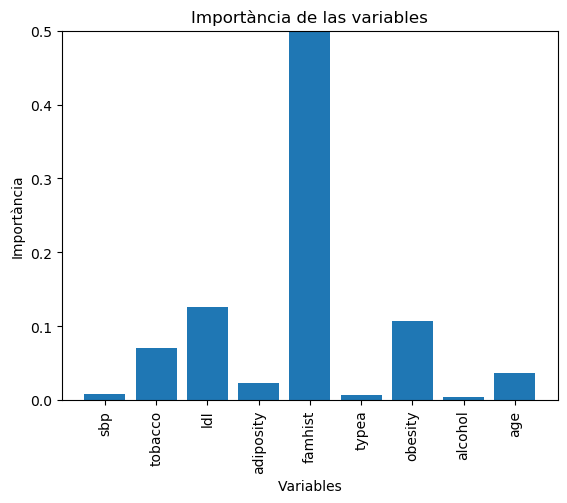

In [ ]:
nombres_variables = ['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'alcohol', 'age']
importancia_variables = np.abs(lr_model.coef_[0])

# Crear un array de posiciones para las barras
posiciones = np.arange(len(nombres_variables))

# Plotear las barras de importancia
plt.bar(posiciones, importancia_variables)

# Añadir etiquetas a las barras
plt.xticks(posiciones, nombres_variables, rotation='vertical')

# Añadir título y etiquetas a los ejes
plt.title('Importància de las variables')
plt.xlabel('Variables')
plt.ylabel('Importància')
plt.ylim(0, 0.5)

# Mostrar el gráfico
plt.show()

#### Preparació de les Dades

En aquest bloc de codi es realitza la preparació de les dades per a l'entrenament i avaluació del model de Regressió Loigítica.

* Eliminació de Columnes (si es requereix):
   Si la variable `remove` és certa, es remouen les columnes 'sbp', 'typea' i 'alcohol' de les dades d'entrenament i de prova. L'elecció  d'aquestes caracterítiques es deguda a l'estudi al bloc de codi anterior.

* Divisió de les Dades d'Entrenament i Validació (si es requereix):
   Si la variable `validation` és certa, una part de les dades de `train` es guardarà com a dades de `validació`. Aquest bloc de dades sùtilitzarà psoteriorment per optimitzar la frontera de decisió $\gamma$.

In [ ]:
remove = False
validation = True

path = '/home/victhor02/Desktop/doc/3B/apa/hearth-disease-predictor/data/'
data = pd.read_csv(path + 'sheart_train_ok.csv')
test = pd.read_csv(path + 'sheart_test_ok.csv')

if(remove):  X = data.drop(['sbp','typea','alcohol','chd'], axis=1)
else:  X = data.drop('chd', axis=1)

if(remove): test = test.drop(['sbp','typea','alcohol'], axis=1)

y = data['chd']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
if(validation): X_train,X_validation,y_train,y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],  # Tipo de regularización (L1 o L2)
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 2000],  # Inverso de la fuerza de regularización
    'solver': ['liblinear', 'saga'],  # Algoritmo de optimización
    'max_iter': [100, 200, 500]  # Número máximo de iteraciones
}


clf_rand = GridSearchCV(lr_model, param_grid, cv=4,scoring=make_scorer(f1_score))
clf_rand.fit(X_train, y_train )

/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter w

GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 2000],
                         'max_iter': [100, 200, 500], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), verbose=0)

In [ ]:
lr = clf_rand.best_estimator_
clf_rand.best_params_

{'C': 100, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
lr.fit(X_train,y_train) # fit random forest on x and y

y_pred_lr = lr.predict(X_test)
print(accuracy_score(y_test, y_pred_lr))
print(f1_score(y_test, y_pred_lr))
cmat = confusion_matrix(y_test,y_pred_lr)
print(cmat)

0.6461538461538462
0.5306122448979592
[[29 13]
 [10 13]]


#### Curva Precision-Recall

Obtenim el valor de la `F1-score` en funció de la frontera de descisó $\gamma$ i ens quedem amb el valor que la maximitza.

0.5126900490228714


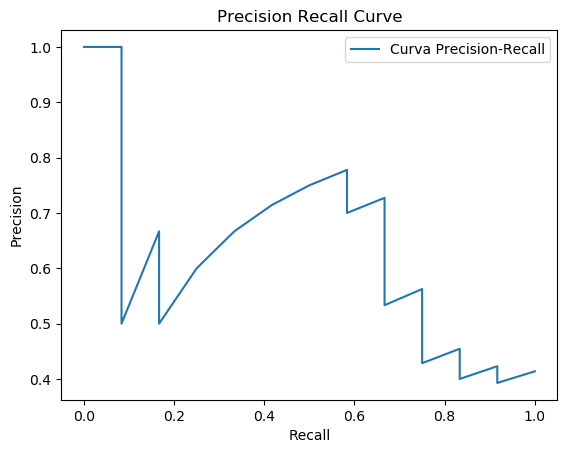

In [ ]:
from sklearn.metrics import precision_recall_curve

if(validation):
    y_prob = lr.predict_proba(X_validation)[:, 1]

    precision, recall, umbrales = precision_recall_curve(y_validation, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    mejor_umbral = umbrales[np.argmax(f1_scores)]
    print(mejor_umbral)
    # Trazar la curva de precisión y recuperación
    plt.plot(recall, precision, label='Curva Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show()


In [ ]:
if(validation):
    y_prob_test = lr.predict_proba(X_test)[:,1]
    y_pred = (y_prob_test >= mejor_umbral).astype(int)
    print(accuracy_score(y_test, y_pred))
    print(f1_score(y_test, y_pred))
    print(recall_score(y_test, y_pred))
    cmat = confusion_matrix(y_test,y_pred)
    print(cmat)

0.6615384615384615
0.5416666666666667
0.5652173913043478
[[30 12]
 [10 13]]


### <span style="color:#6495ED">**4. Gaussian Naive Bayes**</span>

In [ ]:
path = '/home/victhor02/Desktop/doc/3B/apa/hearth-disease-predictor/data/'
train = pd.read_csv(path + 'sheart_train_ok.csv')
test = pd.read_csv(path + 'sheart_test_ok.csv')

X = train.drop('chd', axis=1)
y = train['chd']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred_gnb))
print(f1_score(y_test, y_pred_gnb))
cmat = confusion_matrix(y_test,y_pred_gnb)
print(cmat)

0.7230769230769231
0.5909090909090909
[[34  8]
 [10 13]]


### <span style="color:#6495ED">**5. Random Forest**</span>

In [ ]:
rnf_model = RandomForestClassifier()
rnf_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Obtener la importancia de cada variable
importancia_variables = rnf_model.feature_importances_

# Crear un diccionario que asocie el nombre de cada variable con su importancia
dict_importancia = dict(zip(nombres_variables, importancia_variables))

# Imprimir la importancia de cada variable en orden descendente
for nombre, importancia in sorted(dict_importancia.items(), key=lambda x: x[1], reverse=True):
    print(f'{nombre}: {importancia}')

NameError: name 'nombres_variables' is not defined

In [ ]:
param_grid = [{'n_estimators': [50,100,200],
                'max_depth': range(2,30),
                'max_features':['sqrt',0.2],
                'criterion':['gini','entropy']}]


clf_rand = GridSearchCV(rnf_model, param_grid, cv=2,scoring=make_scorer(f1_score))
clf_rand.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(2, 30),
                          'max_features': ['sqrt', 0.2],
                          'n_estimators': [50, 100, 200]}],
             scoring=make_scorer(f1_score))

In [ ]:
rf = clf_rand.best_estimator_
clf_rand.best_params_

{'criterion': 'gini',
 'max_depth': 23,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [ ]:
rf.fit(X_train,y_train) # fit random forest on x and y

y_pred_lr = rf.predict(X_test)
print(accuracy_score(y_test, y_pred_lr))
print(f1_score(y_test, y_pred_lr))
cmat = confusion_matrix(y_test,y_pred_lr)
print(cmat)

0.6615384615384615
0.5416666666666667
[[30 12]
 [10 13]]


### <span style="color:#6495ED">**6. Voting**</span>

In [ ]:
from sklearn.ensemble import VotingClassifier
voting_hard = VotingClassifier(
    estimators=[('lr', lr), ('gnb', gnb), ('rf', rf)],
    voting='hard'
)
voting_hard.fit(X_train, y_train)

voting_soft = VotingClassifier(
    estimators=[('lr', lr), ('gnb', gnb), ('rf', rf)],
    voting='soft'
)
voting_soft.fit(X_train, y_train)

models = [('lr', lr), ('gnb', gnb), ('rf', rf), ('hard voting', voting_hard), ('soft voting', voting_soft)]

for name, model in models:
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    print(f'F1-score: {f1}')
    print(f'Recall: {recall}')
    print('Confusion Matrix:')
    print(confusion_mat)
    print('------------------------')

Model: lr
Accuracy: 0.6461538461538462
F1-score: 0.5306122448979592
Recall: 0.5652173913043478
Confusion Matrix:
[[29 13]
 [10 13]]
------------------------
Model: gnb
Accuracy: 0.7230769230769231
F1-score: 0.5909090909090909
Recall: 0.5652173913043478
Confusion Matrix:
[[34  8]
 [10 13]]
------------------------
Model: rf
Accuracy: 0.6615384615384615
F1-score: 0.5416666666666667
Recall: 0.5652173913043478
Confusion Matrix:
[[30 12]
 [10 13]]
------------------------
Model: hard voting
Accuracy: 0.6461538461538462
F1-score: 0.5306122448979592
Recall: 0.5652173913043478
Confusion Matrix:
[[29 13]
 [10 13]]
------------------------
Model: soft voting
Accuracy: 0.676923076923077
F1-score: 0.5714285714285715
Recall: 0.6086956521739131
Confusion Matrix:
[[30 12]
 [ 9 14]]
------------------------


#### Entrega

In [ ]:
model = voting_soft
y_pred = model.predict(test)

NameError: name 'voting_soft' is not defined

In [ ]:
data = pd.read_csv("/home/victhor02/Desktop/doc/3B/apa/hearth-disease-predictor/data/sheart_test_ok.csv")
indexes = data.index
indexes = np.add(indexes, 1)
y_pred_format = pd.DataFrame(y_pred,columns=['Label'])
y_pred_format.insert(0, 'Id', indexes)
y_pred_format.to_csv('/home/victhor02/Desktop/doc/3B/apa/hearth-disease-predictor/data/submission_test.csv', index=False)